In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy import units as u

import requests
from bs4 import BeautifulSoup

### Must open website and scrape TLEs

In [2]:
url = 'https://celestrak.org/NORAD/elements/supplemental/sup-gp.php?FILE=starlink&FORMAT=tle'
raw = requests.get(url)
soup = BeautifulSoup(raw.content, 'html.parser')
soup = str(soup.get_text()).splitlines()

In [3]:
print(raw.headers['content-type'])
print(raw.encoding)

text/plain; charset=UTF-8
UTF-8


In [4]:
def old_method():

    # Create empty dataframe        
    cols = ['name', 'sat_num', 'int_desig', 'epoch','1d_mm', 
            '2d_mm', 'bstar', 'eph_type', 'checksum1', 'inc',
            'raan', 'ecc', 'argp', 'ma', 'mm', 'checksum2']
    df = pd.DataFrame(columns=cols)


    # Extract elements from scraped data
    n=0
    arr = np.empty(16, dtype='U25')
    for row in soup:
        data = row.split(" ")

        # Row 1
        if n==0:
            arr[0] = data[0].strip('\n')
            n+=1

        # Row 2
        elif n==1:
            data = list(filter(None, data))
            n+=1

            for i in range(8):
                arr[i+1] = data[i+1] #don't care about line number

        # Row 3
        elif n==2:
            data = list(filter(None, data))

            for i in range(7):
                arr[i+9] = data[i+1] 

            df = df.append(pd.DataFrame(arr.reshape(1,-1), columns=list(df)), ignore_index=True)
            arr = np.empty(16, dtype='U25')
            n=0

In [6]:
def slow_method():

    cols = ['name', 'sat_num1', 'int_desig', 'epoch','1d_mm', 
            '2d_mm', 'bstar', 'eph_type', 'checksum1', 'sat_num2', 
            'inc', 'raan', 'ecc', 'argp', 'ma', 'mm', 'checksum2']

    df = pd.DataFrame(columns=cols)

    n = 0
    x = []
    for row in soup:
        data = row.split(' ')

        if n==0:
            x.append(data[0])

        elif ((n==1) | (n==2)):
            data = list(filter(None, data))
            x.extend(data[1:])    

        n+=1
        if n>2:
            df.loc[len(df)] = x
            n = 0
            x = []

In [5]:
def tle_to_df():
    n = 0
    x = []
    y = []
    
    for row in soup:
        data = row.split(' ')

        if n==0:
            x.append(data[0])

        elif ((n==1) | (n==2)):
            data = list(filter(None, data))
            x.extend(data[1:])    

        n+=1
        if n>2:
            y.append(x)
            n = 0
            x = []

    cols = ['name', 'sat_num1', 'int_desig', 'epoch','1d_mm', 
            '2d_mm', 'bstar', 'eph_type', 'checksum1', 'sat_num2', 
            'inc', 'raan', 'ecc', 'argp', 'ma', 'mm', 'checksum2']

    return pd.DataFrame(y, columns=cols)


df = tle_to_df()

### Skyfield

In [5]:
from skyfield.api import load, wgs84, EarthSatellite
from skyfield.timelib import Time

In [6]:
sats = load.tle_file(url)
print('Loaded', len(sats), 'Starlink satellites')

Loaded 3102 Starlink satellites


In [7]:
sats[0].epoch.utc_jpl()

'A.D. 2022-Sep-28 01:13:42.0004 UTC'

### SGP4 to get position / speed vectors

In [8]:
from skyfield.api import load
from sgp4.api import Satrec
from sgp4.api import jday

In [9]:
sats = load.tle_file(url)
print('Loaded', len(sats), 'Starlink satellites')

Loaded 3102 Starlink satellites


In [64]:
def tle_df():
    n = 0
    x = []
    y = []
    z = []
    
    for row in soup:
        data = row.split('\n')

        if n==0:
            x.append(data[0])
            n = 1

        elif n==1:
            y.append(data[0])
            n = 2
            
        elif n==2:
            z.append(data[0])
            n = 0

    df = pd.DataFrame(columns=['name', 'l1', 'l2'])
    df.name = x
    df.l1 = y
    df.l2 = z
    
    return df


df = tle_df()

In [11]:
sat = Satrec.twoline2rv(df.l1[0], df.l2[0])

In [12]:
from sys import stdout
from sgp4.conveniences import dump_satrec

stdout.writelines(dump_satrec(sat))


# -------- Identification --------
satnum = 44713
classification = 'C'
ephtype = 0
elnum = 271
revnum = 1

# -------- Orbital Elements --------
epochyr = 22
epochdays = 271.05118056
ndot = 4.917828777754855e-11
nddot = 0.0
bstar = 0.00010873
inclo = 0.9259757079993315
nodeo = 1.3415351122406773
ecco = 0.0001576
argpo = 1.3920152701961095
mo = 4.158198073657434
no_kozai = 0.06572871107618172
no = 0.06572871107618172
jdsatepoch = 2459850.5
jdsatepochF = 0.05118056

# -------- Computed Orbit Properties --------
a = 1.085841613303433
altp = 0.08567048466517635
alta = 0.08601274194168962
argpdot = 3.640892002182369e-05
gsto = 0.440351575205149
mdot = 0.06572871765562044
nodedot = -5.44247818581249e-05

# -------- Propagator Mode --------
operationmode = 'i'
method = 'n'

# -------- Result of Most Recent Propagation --------
t = 0.0
error = 0

# -------- Mean Elements From Most Recent Propagation --------
am = 1.085841613303433
em = 0.0001576
im = 0.9259757079993315

# -------- Om --------


In [63]:
jd, fr = jday(2022, 9, 22, 11, 59, 33)
e, r, v = sat.sgp4(jd, fr)

print('Error: {}'.format(e))
print('Pos Vector: {}'.format(r)) # True Equator Mean Equinox position (km)
print('Vel Vector: {}'.format(v)) # True Equator Mean Equinox velocity (km/s)



# r measures the satellite position in kilometers from the center of the earth in the idiosyncratic True Equator 
# Mean Equinox coordinate frame used by SGP4.

# v velocity is the rate at which the position is changing, expressed in kilometers per second.

Error: 0
Pos Vector: (-4294.917853952, 849.4299138840522, 5355.807006085412)
Vel Vector: (0.4017208522512714, -7.432374391044285, 1.4977912532962696)


In [14]:
timescale = load.timescale()
t = timescale.now()
print(t.utc_jpl())

A.D. 2022-Sep-28 11:28:39.4662 UTC


In [16]:
jd, fr = jday(2022, 9, 23, 15, 38, 33)

In [17]:
sat = Satrec.twoline2rv(df.l1[0], df.l2[0])
jd = sat.jdsatepoch
fr = sat.jdsatepochF

e, r, v = sat.sgp4(jd, fr)
print('Error: {}'.format(e))
print('Pos Vector: {}'.format(r))
print('Vel Vector: {}'.format(v))

Error: 0
Pos Vector: (3888.788908992739, 4373.388805256777, -3711.4221927832073)
Vel Vector: (-2.139106064306445, 5.715131234726723, 4.499982068096372)


### Note about epoch:
Over a given satellite’s lifetime, dozens or hundreds of different TLE records will be produced as its orbit evolves. Each TLE record specifies the “epoch date” for which it is most accurate. Typically a TLE is only useful for a couple of weeks to either side of its epoch date, beyond which its predictions become unreliable.

Satellite objects natively provide their epoch as a two-digit year and then a fractional number of days into the year:

In [122]:
def tle_vec_df():
    n = 0
    x = []
    y = []
    z = []
    
    for row in soup:
        data = row.split('\n')

        if n==0:
            x.append(data[0])
            n = 1

        elif n==1:
            y.append(data[0])
            n = 2
            
        elif n==2:
            z.append(data[0])
            n = 0
    
    df = pd.DataFrame(columns=['name', 'l1', 'l2', 'r_vec', 'v_vec'])
    df.name = x
    df.l1 = y
    df.l2 = z
    
    r_vec = []
    v_vec = []
    for index, row in df.iterrows():
        sat = Satrec.twoline2rv(row['l1'], row['l2'])
        e, r, v = sat.sgp4(sat.jdsatepoch, sat.jdsatepochF)
        r_vec.append(r)
        v_vec.append(v)
        
    df.r_vec = r_vec
    df.v_vec = v_vec
    
    
    return df


df = tle_vec_df()

In [60]:
# create a position in the TEME reference frame
from datetime import datetime
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import TEME, CartesianDifferential, CartesianRepresentation

now = datetime.now().isoformat()
t = Time(now, format='isot')
t.format = 'jd'

r = df.r_vec[0]
v = df.v_vec[0]

teme_r = CartesianRepresentation(r*u.km)
teme_v = CartesianDifferential(v*u.km/u.s)
teme = TEME(teme_r.with_differentials(teme_v), obstime=t)

teme

<TEME Coordinate (obstime=2459851.112737344): (x, y, z) in km
    (3888.78890899, 4373.38880526, -3711.42219278)
 (v_x, v_y, v_z) in km / s
    (-2.13910606, 5.71513123, 4.49998207)>

In [61]:
r

(3888.788908992739, 4373.388805256777, -3711.4221927832073)

In [62]:
teme_r

<CartesianRepresentation (x, y, z) in km
    (3888.78890899, 4373.38880526, -3711.42219278)>

### Transforming TEME to Other Coordinate Systems ---> astropy.coordinates

For example, to find the overhead latitude, longitude, and height of the satellite: International Terrestrial Reference System (ITRS).

This is approximately a geocentric system, although strictly it is defined by a series of reference locations near the surface of the Earth.

In [28]:
from astropy.coordinates import ITRS 
itrs = teme.transform_to(ITRS(obstime=t))  
location = itrs.earth_location
location.geodetic  

GeodeticLocation(lon=<Longitude -161.18246431 deg>, lat=<Latitude -32.54239211 deg>, height=<Quantity 557.94164549 km>)

In [18]:
import cartopy.crs as ccrs

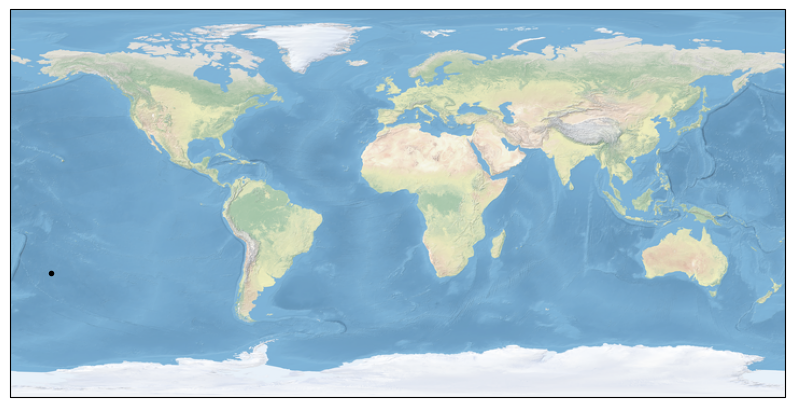

In [19]:
plt.figure(figsize=(10, 15))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()

plt.scatter(location.geodetic.lon, location.geodetic.lat, color='k', marker='.') #transform=ccrs.Geodetic()

plt.show()

In [55]:
def get_locations_now():
    
    df = tle_vec_df()
    now = datetime.now().isoformat()
    t = Time(now, format='isot')
    t.format = 'jd'

    r = df.r_vec
    v = df.v_vec
    
    lats = []
    lons = []
    
    for elem in list(zip(r,v)):
        teme_r = CartesianRepresentation(elem[0]*u.km)
        teme_v = CartesianDifferential(elem[1]*u.km/u.s)
        teme = TEME(teme_r.with_differentials(teme_v), obstime=t)
        
        itrs = teme.transform_to(ITRS(obstime=t))  
        location = itrs.earth_location
        lats.append(location.geodetic.lat.value) 
        lons.append(location.geodetic.lon.value) 

    return lats, lons

In [56]:
lats, lons = get_locations_now()

In [59]:
teme

<TEME Coordinate (obstime=2459851.0797193795): (x, y, z) in km
    (3888.78890899, 4373.38880526, -3711.42219278)
 (v_x, v_y, v_z) in km / s
    (-2.13910606, 5.71513123, 4.49998207)>

In [52]:
def get_locations_now():
    
    df = tle_vec_df()
    now = datetime.now().isoformat()
    t = Time(now, format='isot')
    t.format = 'jd'

    r = df.r_vec
    v = df.v_vec
    
    lats = []
    lons = []
    
    for elem in list(zip(r,v)):
        teme_r = CartesianRepresentation(elem[0]*u.km)
        teme_v = CartesianDifferential(elem[1]*u.km/u.s)
        itrs = ITRS(teme_r.with_differentials(teme_v), obstime=t, representation_type='cartesian')
        location = itrs.earth_location
        lats.append(location.geodetic.lat.value) 
        lons.append(location.geodetic.lon.value) 

    return lats, lons

In [53]:
lats, lons = get_locations_now()

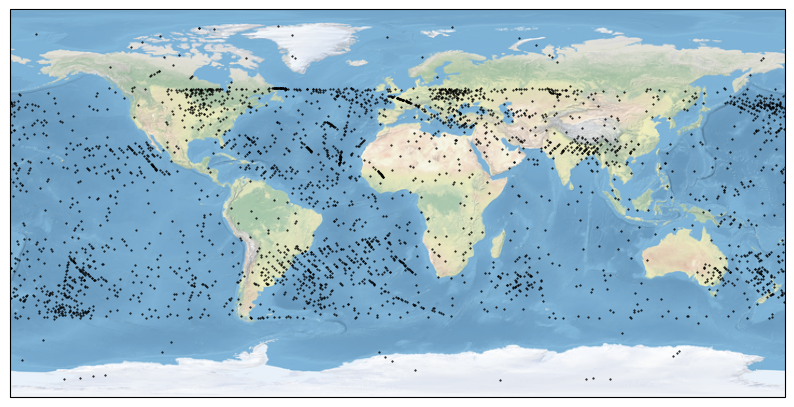

In [54]:
plt.figure(figsize=(10, 15))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()

plt.scatter(lons, lats, color='k', marker='.', s=1, transform=ccrs.Geodetic()) #transform=ccrs.Geodetic()

plt.show()

In [177]:
from skyfield.api import EarthSatellite

df2 = tle_df()
ts = load.timescale()
satellite = EarthSatellite(df2.l1[0], df2.l2[0], df2.name[0], ts)

t = ts.now()
geocentric = satellite.at(t)
geocentric.position.km

array([ 4103.02825082,  4115.28430199, -3775.49386666])

In [134]:
EarthLocation(geocentric.position.km[0]*u.km, geocentric.position.km[1]*u.km, geocentric.position.km[2]*u.km)

<EarthLocation (-482.49947117, -6676.15608102, -1788.82252105) km>

In [124]:
now = datetime.now().isoformat()
t = Time(now, format='isot')
t.format = 'jd'

r = df.r_vec[0]
v = df.v_vec[0]

teme_r = CartesianRepresentation(r*u.km)
teme_v = CartesianDifferential(v*u.km/u.s)
teme = TEME(teme_r.with_differentials(teme_v), obstime=t)
teme

<TEME Coordinate (obstime=2459851.1433311943): (x, y, z) in km
    (3888.78890899, 4373.38880526, -3711.42219278)
 (v_x, v_y, v_z) in km / s
    (-2.13910606, 5.71513123, 4.49998207)>

In [141]:
itrs = teme.transform_to(ITRS(obstime=t))  
itrs

<ITRS Coordinate (obstime=2459851.1433311943): (x, y, z) in km
    (-5751.82884701, 1079.69551344, -3711.41294209)
 (v_x, v_y, v_z) in km / s
    (-3.71737551, -4.35844366, 4.49998159)>

# TIDY

In [ ]:
import requests
import pandas as pd

url = 'https://celestrak.org/NORAD/elements/supplemental/sup-gp.php?FILE=starlink&FORMAT=tle'

raw = requests.get(url)
soup = BeautifulSoup(raw.content, 'html.parser')
soup = str(soup.get_text()).splitlines()

In [ ]:
from sgp4.api import Satrec, jday
from datetime import datetime
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import TEME, CartesianDifferential, CartesianRepresentation

def sgp4_method():

    df = tle_vec_df()
    now = datetime.now().isoformat()
    t = Time(now, format='isot')
    t.format = 'jd'

    r = df.r_vec
    v = df.v_vec
    
    lats = []
    lons = []
    
    for elem in list(zip(r,v)):
        teme_r = CartesianRepresentation(elem[0]*u.km)
        teme_v = CartesianDifferential(elem[1]*u.km/u.s)
        itrs = ITRS(teme_r.with_differentials(teme_v), obstime=t, representation_type='cartesian')
        location = itrs.earth_location
        lats.append(location.geodetic.lat.value) 
        lons.append(location.geodetic.lon.value) 

    return lats, lons

In [193]:
from bs4 import BeautifulSoup
from skyfield.api import load, EarthSatellite
    
def skyfield_method():

    sats = load.tle_file(url)
    print('Loaded', len(sats), 'Starlink satellites')
    
    df = tle_vec_df()
    t = load.timescale().now()
    
    r = []
    v = []
    
    for sat in sats:
        geocentric = sat.at(t)
        r.append(geocentric.position.km)        # geocentric.position.to(u.km)
        v.append(geocentric.velocity.km_per_s)
    
    return r, v    

r, v = skyfield_method()

Loaded 3102 Starlink satellites


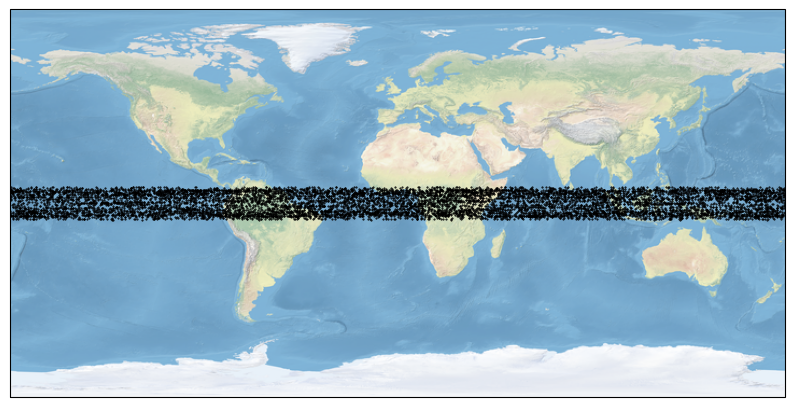

In [195]:
plt.figure(figsize=(10, 15))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()

plt.scatter(r, v, color='k', marker='.', s=1)

plt.show()

In [223]:
from bs4 import BeautifulSoup
from skyfield.api import load, EarthSatellite

from skyfield.api import wgs84
from skyfield.framelib import itrs
    
def skyfield_geodesic_latlon():

    sats = load.tle_file(url)
    print('Loaded', len(sats), 'Starlink satellites')
    
    df = tle_vec_df()
    t = load.timescale().now()
    
    # CARTESIAN: x, y, z = geocentric.position.frame_xyz(itrs).km
    
    lats = []
    lons = []
    for sat in sats:
        geocentric = sat.at(t)  
        lat, lon = wgs84.latlon_of(geocentric) # Geodetic latitude and longitude
        lats.append(lat.degrees)
        lons.append(lon.degrees)
    
    return lats, lons   

lats, lons = skyfield_geodesic_latlon()

Loaded 3102 Starlink satellites


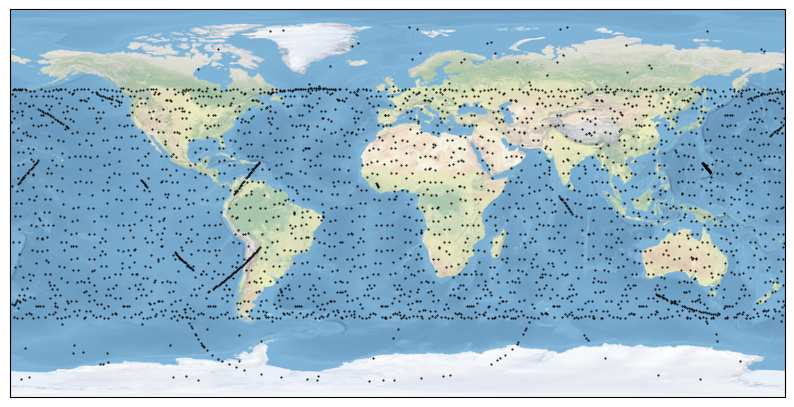

In [226]:
plt.figure(figsize=(10, 15))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()

plt.scatter(lons, lats, color='k', marker='.', s=1, transform=ccrs.Geodetic())

plt.show()

In [219]:
from bs4 import BeautifulSoup
from skyfield.api import load, EarthSatellite

from skyfield.api import wgs84
from skyfield.framelib import itrs
    
def skyfield_geodesic_xyz():

    sats = load.tle_file(url)
    print('Loaded', len(sats), 'Starlink satellites')
    
    df = tle_vec_df()
    t = load.timescale().now()
    
    coords = []
    for sat in sats:
        geocentric = sat.at(t) 
        coord = wgs84.geographic_position_of(geocentric) # the position’s geodetic latitude and longitude
        coords.append(coord)
    
    return coords

x = skyfield_geodesic_xyz()

Loaded 3102 Starlink satellites


# RW

In [ ]:
from datetime import datetime, timedelta
import pandas as pd
dates = pd.date_range(start=datetime.now(), periods=1000, freq='30S')

now = load.timescale().now()
ts = load.timescale()
now.utc

dates = [datetime.now() - timedelta(minutes=x) for x in range(200)]
# t = ts.from_datetime()

t = ts.utc(now.utc[0], now.utc[1], now.utc[2], now.utc[3], now.utc[4], range(100)) # t.utc_datetime()